<a href="https://colab.research.google.com/github/Virajsawant06/FER-Capstone/blob/main/FER_with_Google_Meet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-expression-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F99505%2F234911%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241012%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241012T045214Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D95849f6897f09384149f4d755ea45357492cf44e253fee1f347fac55d5c83229486a34609c92f0f657179e3cc32c835dac9e740ff604df4f9f0b69d9d737304c1808a631633ca08facdae61550dba505a1eac9c7abd58f8b639e437f333fc4a6c1b7fc2a6df989b2b81b3f83489318947969d8833ff2937aaf05cefbf74d4846aa67adc04e4204fecd40e2057dfe7a7d62d24b1b0345caa2ebaae4c48df3f7e649c769ee64b18e72e979975bbf31925607727cabe079b43424b4ec6b80cb513862c65b94ee29a467b6c9e71d1590b309a617481004e8f48cb6a7b2514cb4176b7e5592dd07e5788d6627d33a88f38cfdf8da4635a06bd432b208ebdd1d7ffb40,fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241012%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241012T045214Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D21b8d7ee80929757c679519add21e5bac4d6027a3e95ce14129411afc2d3c5505eaa402ab8bc7a5dcf6ad89cf373e06e7a547038e9fc1f788bcf71d719b458084d8e152c4527eaa98b4793adcdb17dadc0b62e1d8f001251e3210b1b5255cb378a866da8fa82efd1df7cdaa0d12d5d9a5f5ea760d049ba4c80a9e77314ad61475af8b6b2fbee45404bb8126d0fb5c720b70f0adef962c0ba898fb6a5584c6ac1065dcce933856a0f48d8134ab58b373a0babcbc3c1ed6fa484b6565a1d2de7350861704d7b14fb7a49c0e6f10e497beebbae5008800b4ac6095a80b220afa38f01523c6981b546e939185b57fcfbd6991238a5046a5dce85427120fa02807905'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 126358582 bytes downloaded
Downloaded and uncompressed: face-expression-recognition-dataset
[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import image_dataset_from_directory  # Use this instead of ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Flatten, Dense
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.losses import categorical_crossentropy

In [3]:
picture_size = 48
folder_path = "/kaggle/input/fer2013"

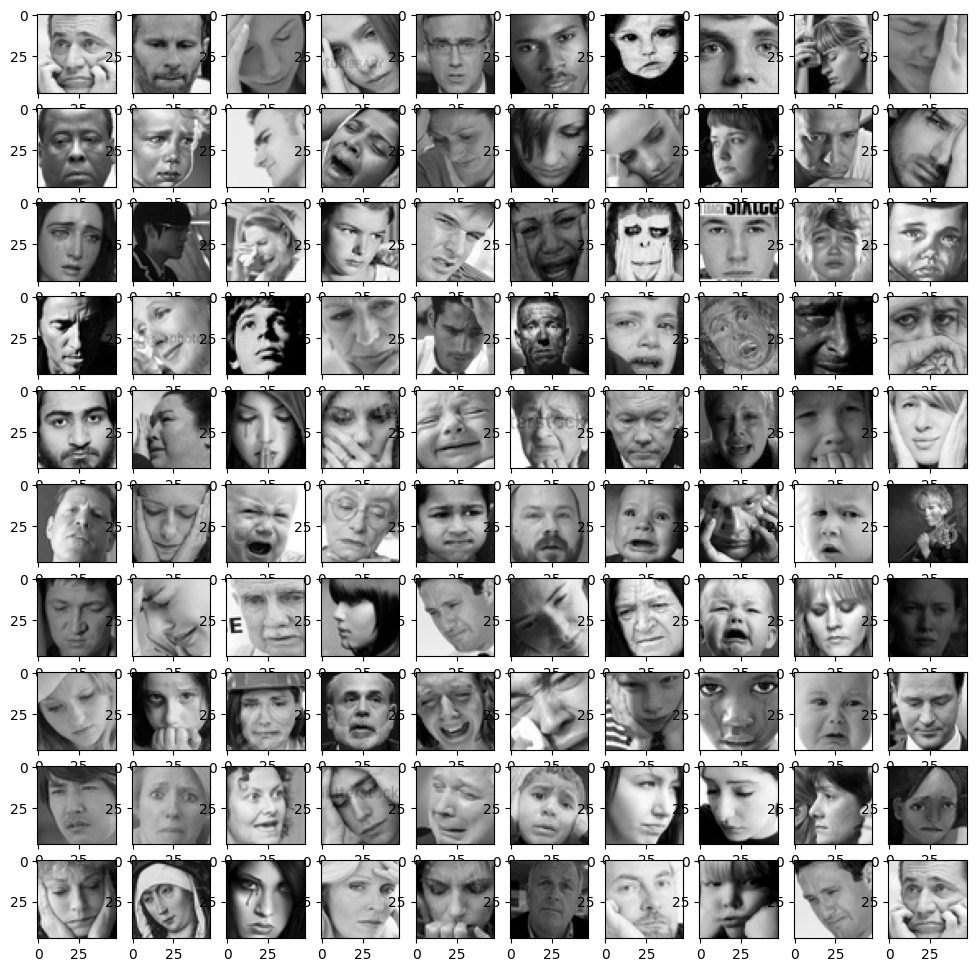

In [4]:
expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 101):
    plt.subplot(10,10,i)
    img = load_img(folder_path+"/train"+"/"+expression+"/"+
                  os.listdir(folder_path + "/train" +"/"+ expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [5]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"/train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"/test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [7]:
# Working with pre trained model

base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=7 , activation='softmax' )(x)

# creating our model.
model = Model(base_model.input, x)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

# **GENERATING DATA**

In [9]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     horizontal_flip=True,
     rescale = 1./255
)

train_set = datagen_train.flow_from_directory(folder_path+"/train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)



train_set.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

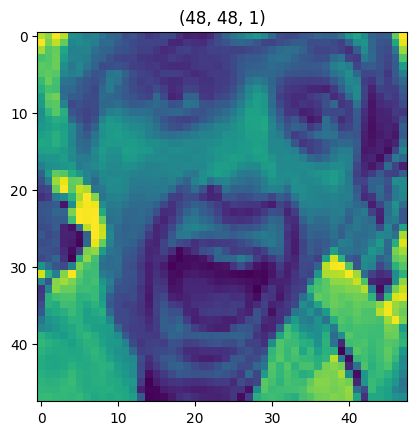

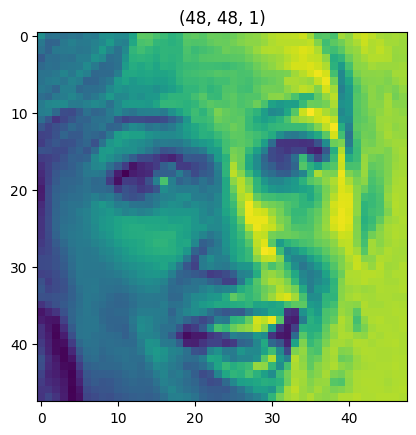

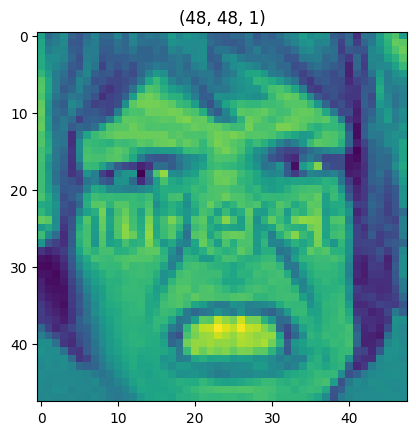

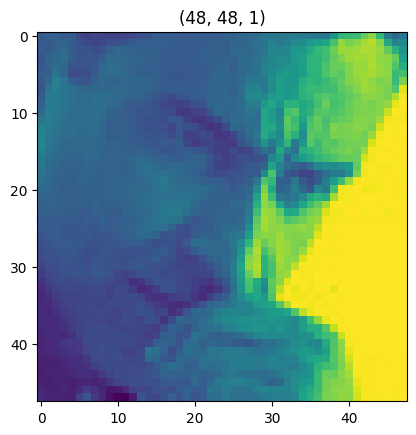

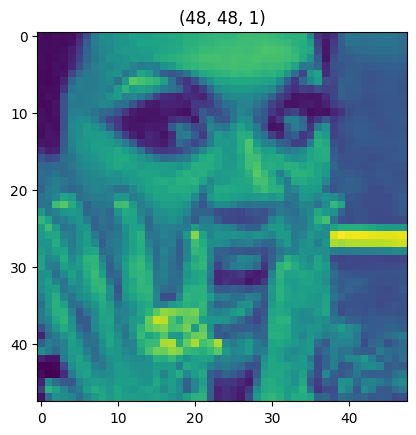

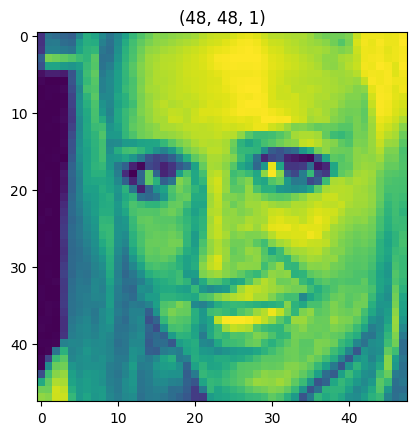

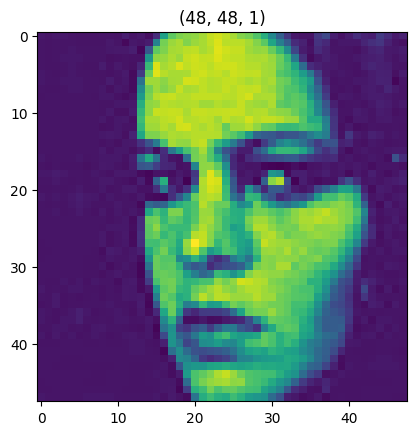

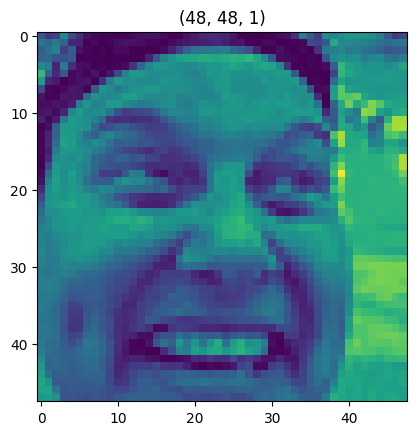

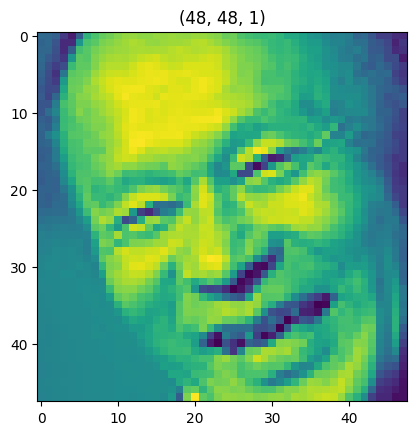

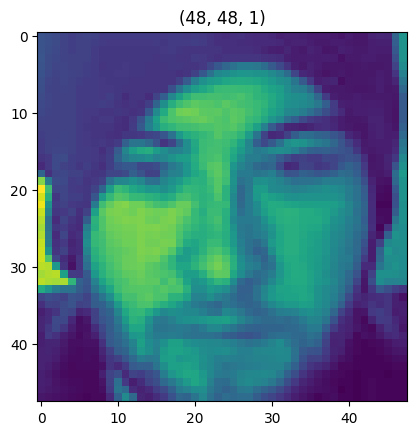

In [10]:
# to visualize the images in the traing data denerator

t_img, label = next(train_set)




# function when called will prot the images
def plotImages(img_arr, label):
  """
  input  :- images array
  output :- plots the images
  """
  count = 0
  for img, data in zip(img_arr,label) :
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis = False
    plt.show()

    count += 1
    if count == 10:
      break

#-----------------------------------------------------------------------------
# function call to plot the images
plotImages(t_img, label)

# **MODEL**

In [11]:
train_set = datagen_train.flow_from_directory(
    folder_path+"/train",
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=128,
    class_mode='categorical')

test_set = datagen_val.flow_from_directory(
    folder_path+"/test",
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=128,
    class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:

## having early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

# early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# model check point
mc = ModelCheckpoint(filepath="ferModel.keras", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# puting call back in a list
call_back = [es, mc]

In [13]:
hist = model.fit(train_set,
                           steps_per_epoch= 10,
                           epochs= 30,
                           validation_data= test_set,
                           validation_steps= 8,
                           callbacks=[es,mc])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1746 - loss: 11.9570
Epoch 1: val_accuracy improved from -inf to 0.23242, saving model to ferModel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 131s 13s/step - accuracy: 0.1767 - loss: 11.9976 - val_accuracy: 0.2324 - val_loss: 9.8123
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2862 - loss: 8.2494
Epoch 2: val_accuracy improved from 0.23242 to 0.29297, saving model to ferModel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 119s 12s/step - accuracy: 0.2838 - loss: 8.1301 - val_accuracy: 0.2930 - val_loss: 5.1941
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2551 - loss: 4.4701
Epoch 3: val_accuracy improved from 0.29297 to 0.33984, saving model to ferModel.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 116s 12s/step - accuracy: 0.2572 - loss: 4.4433 - val_accuracy: 0.3398 - val_loss: 3.9963
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3310 - loss: 3.4502
Epoch 4: val_accuracy did not improve from 0.33984
10/10 ━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.4262 - loss: 2.2907 - val_accuracy: 0.4000 - val_loss: 2.7192
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4235 - loss: 2.2200
Epoch 9: val_accuracy did not improve from 0.40000
10/10 ━━━━━━━━━━━━━━━━━━━━ 116s 12s/step - accuracy: 0.4222 - loss: 2.2207 - val_accuracy: 0.3604 - val_loss: 2.8501
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4179 - loss: 2.1573
Epoch 10: val_accuracy did not improve from 0.40000
10/10 ━━━━━━━━━━━━━━━━━━━━ 111s 11s/step - accuracy: 0.4165 - loss: 2.1661 - val_accuracy: 0.3135 - val_loss: 2.7098
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4192 - loss: 2.3254
Epoch 11: val_accuracy did not improve from 0.40000
10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.4191 - loss: 2.3378 - val_accuracy: 0.3496 - val_loss: 2.6025
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4075 - loss: 2.2246
Epoch 12: val_accuracy did not improve from 